In [1]:
from argparse import ArgumentParser, Namespace
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm, trange

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append(str(Path(".").resolve().parent))

In [4]:
natural_language_stimulus_path = "heilbron2022/old-man-and-the-sea/run1.pkl"

---

In [5]:
with Path(natural_language_stimulus_path).open("rb") as f:
    stim = pickle.load(f)

In [6]:
print("Num words:", len(stim.word_lengths))
print("Num candidates:", stim.p_candidates.shape[-1])

Num words: 557
Num candidates: 1000


Text(0.5, 0, 'Ground-truth word log-probability')

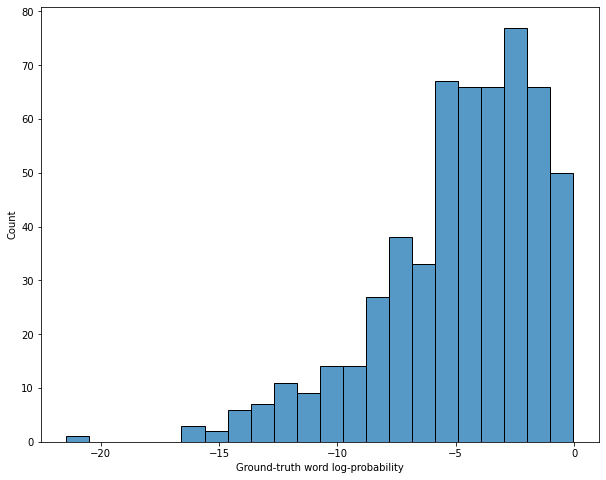

In [7]:
gt_word_probs = stim.p_candidates[:, 0].numpy()

plt.subplots(figsize=(10, 8))
sns.histplot(gt_word_probs)
plt.xlabel("Ground-truth word log-probability")

In [8]:
candidate_phonemes = stim.candidate_phonemes

In [9]:
candidate_lengths = (candidate_phonemes != stim.pad_phoneme_id).sum(dim=2)
gt_lengths, candidate_lengths = candidate_lengths[:, 0], candidate_lengths[:, 1:]
candidate_mean_lengths = candidate_lengths.float().mean(dim=1)

<AxesSubplot:title={'center':'Candidate lengths (in phonemes)'}, ylabel='Count'>

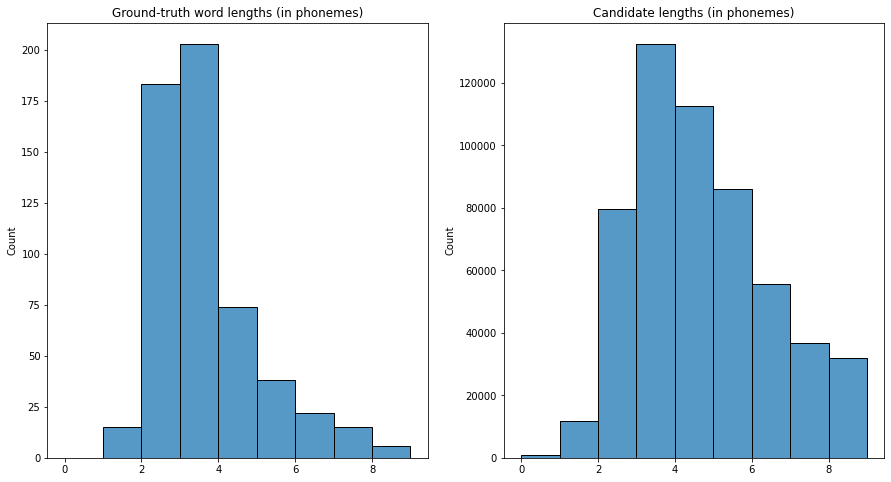

In [11]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
ax1.set_title("Ground-truth word lengths (in phonemes)")
ax2.set_title("Candidate lengths (in phonemes)")

max_length = max(candidate_lengths.max(), gt_lengths.max())
sns.histplot(gt_lengths.numpy(), bins=np.arange(max_length), ax=ax1)
sns.histplot(candidate_lengths.flatten().numpy(), bins=np.arange(max_length), ax=ax2)

In [12]:
# For each candidate, is it a cohort competitor with ground truth?
# Compute this in batches because it's expensive
max_num_phonemes = candidate_phonemes.shape[2]
is_cohort_competitor = []
batch_size = 256
for i in trange(0, candidate_phonemes.shape[0] + batch_size, batch_size):
    batch = candidate_phonemes[i:i+batch_size]
    if len(batch) == 0:
        break
        
    is_cohort_competitor.append(
        (batch[:, 1:] == batch[:, :1]).cumsum(dim=2) == torch.arange(1, max_num_phonemes + 1))
is_cohort_competitor = torch.concat(is_cohort_competitor, dim=0)

  0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
# plt.title("Fraction of candidates which are incremental cohort competitors, by phoneme position")
# sns.lineplot(data=pd.DataFrame(is_cohort_competitor.reshape(-1, max_num_phonemes).numpy()).melt(var_name="phoneme", value_name="is_competitor"),
#              x="phoneme", y="is_competitor", ci=None)

In [13]:
print("Percentage of words which have a candidate which is a cohort competitor for at least one phoneme:",
      is_cohort_competitor.any(dim=2).any(dim=1).float().mean().item() * 100)

Percentage of words which have a candidate which is a cohort competitor for at least one phoneme: 100.0


In [14]:
print("Percentage of words which have a candidate which is a cohort competitor at phoneme X:\n",
      pd.DataFrame(is_cohort_competitor.any(dim=1).float().mean(dim=0).numpy() * 100))

Percentage of words which have a candidate which is a cohort competitor at phoneme X:
             0
0  100.000000
1   88.150803
2   58.168762
3   42.369839
4   39.497307
5   38.599640
6   38.240578
7   38.240578
8   38.240578
9   38.240578


Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort: 0.006728775799274445
Max candidate/ground-truth probability ratio for candidates which share ground truth's cohort: 0.7360947132110596


Text(0.5, 1.0, 'max ratio')

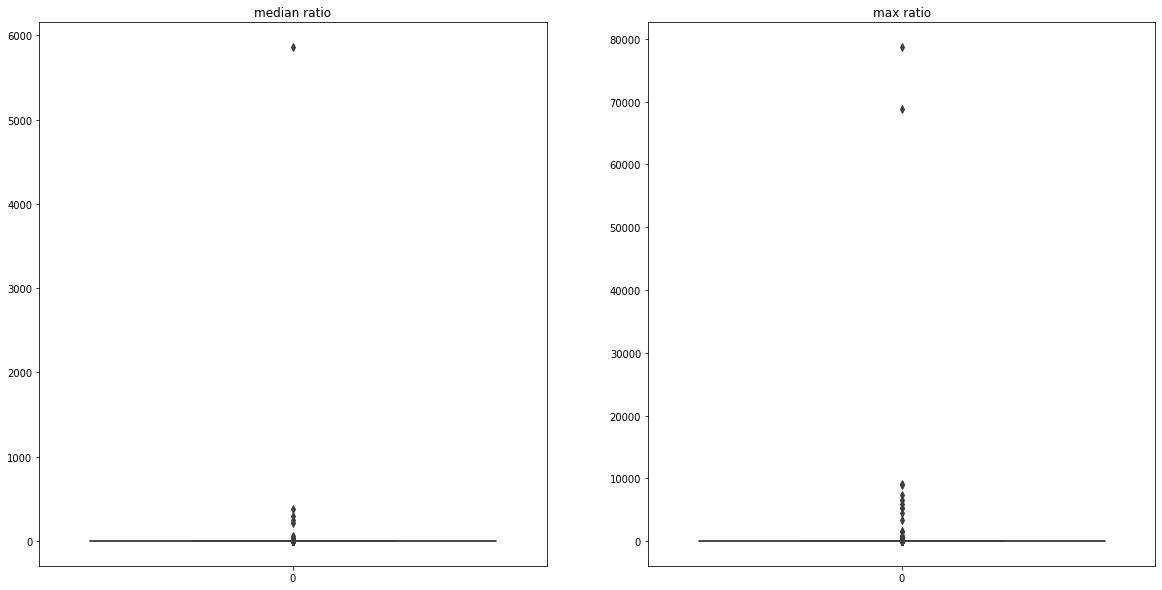

In [42]:
candidate_competitors = is_cohort_competitor.any(dim=2)
gt_probability_ratios = stim.p_candidates[:, 1:].exp() / stim.p_candidates[:, :1].exp()

# Compute median first across each prior distribution
gt_probability_ratios[~candidate_competitors] = np.nan
median_gt_probability_ratio, _ = torch.nanmedian(gt_probability_ratios, axis=1)
gt_probability_ratios_formax = gt_probability_ratios[:]
gt_probability_ratios_formax[gt_probability_ratios_formax.isnan()] = 0.
max_gt_probability_ratio, _ = gt_probability_ratios_formax.max(axis=1)

print("Median candidate/ground-truth probability ratio for candidates which share ground truth's cohort:", 
      median_gt_probability_ratio.median().item())
print("Max candidate/ground-truth probability ratio for candidates which share ground truth's cohort:",
      max_gt_probability_ratio.median().item())

f, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(data=median_gt_probability_ratio.numpy(), ax=axs[0])
axs[0].set_title("median ratio")
sns.boxplot(data=max_gt_probability_ratio.numpy(), ax=axs[1])
axs[1].set_title("max ratio")

In [16]:
def visualize_candidates(word_idx):
    all_cands = stim.get_candidate_strs(word_idx)
    competitor_mask = [np.inf] + is_cohort_competitor[word_idx].sum(dim=1).tolist()
    return sorted([(count, cand) for cand, count in zip(all_cands, competitor_mask) if count > 0], reverse=True)

In [17]:
visualize_candidates(0)

[(inf, ('w', 'ʌ', 'z')),
 (10, ('w', 'ʌ', 'z')),
 (10, ('w', 'ʌ', 'z')),
 (2, ('w', 'ʌ', 't')),
 (2, ('w', 'ʌ', 't')),
 (2, ('w', 'ʌ', 'n', 's')),
 (2, ('w', 'ʌ', 'n')),
 (2, ('w', 'ʌ', 'n')),
 (2, ('w', 'ʌ', 'n')),
 (1, ('w', 'ʊ', 'd')),
 (1, ('w', 'ʊ', 'd')),
 (1, ('w', 'ʊ', 'd')),
 (1, ('w', 'ɪ', 'θ', 'aʊ', 't')),
 (1, ('w', 'ɪ', 'ð')),
 (1, ('w', 'ɪ', 'ð')),
 (1, ('w', 'ɪ', 'ð')),
 (1, ('w', 'ɪ', 'ð')),
 (1, ('w', 'ɪ', 'tʃ')),
 (1, ('w', 'ɪ', 'tʃ')),
 (1, ('w', 'ɪ', 'tʃ')),
 (1, ('w', 'ɪ', 'n', 'd', 'oʊ', 'z')),
 (1, ('w', 'ɪ', 'n')),
 (1, ('w', 'ɪ', 'l')),
 (1, ('w', 'ɪ', 'l')),
 (1, ('w', 'ɛɪ')),
 (1, ('w', 'ɛ', 'ɹ')),
 (1, ('w', 'ɛ', 'ð', 'ɚ')),
 (1, ('w', 'ɛ', 's', 't')),
 (1, ('w', 'ɛ', 'n')),
 (1, ('w', 'ɛ', 'n')),
 (1, ('w', 'ɛ', 'l', 'k', 'ʌ', 'm')),
 (1, ('w', 'ɛ', 'l')),
 (1, ('w', 'ɛ', 'b')),
 (1, ('w', 'ɚ', 'l', 'd')),
 (1, ('w', 'ɚ', 'k')),
 (1, ('w', 'ɚ')),
 (1, ('w', 'ɚ')),
 (1, ('w', 'ɔ', 'ɹ')),
 (1, ('w', 'ɔ', 't', 'ɚ')),
 (1, ('w', 'ɑ', 'ʃ', 'ɪ', 'ŋ', 't', 'ʌ', 'n

In [20]:
candidate_phonemes[1, 0]

tensor([22,  6, 39, 39, 39, 39, 39, 39, 39, 39])

In [21]:
visualize_candidates(10)

[(inf, ('ɪ', 'n')),
 (10, ('ɪ', 'n')),
 (10, ('ɪ', 'n')),
 (10, ('ɪ', 'n')),
 (2, ('ɪ', 'n', 't', 'u')),
 (2, ('ɪ', 'n', 's', 't', 'ɛ', 'd')),
 (1, ('ɪ', 'ʃ')),
 (1, ('ɪ', 'ɹ', 'i')),
 (1, ('ɪ', 'ŋ')),
 (1, ('ɪ', 'z')),
 (1, ('ɪ', 't')),
 (1, ('ɪ', 't')),
 (1, ('ɪ', 'f')),
 (1, ('ɪ', 'd'))]